In [2]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


2023-08-23 14:02:32.768051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-23 14:02:32.797074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-23 14:02:32.797335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Step 1: Load Data

In [5]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

In [6]:
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [7]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    './data/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    './data/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

Found 5117 files belonging to 2 classes.


2023-08-23 14:02:35.517251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-23 14:02:35.517590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-23 14:02:35.517918: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-23 14:02:36.248163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-23 14:02:36.248553: I tensorflow/compile

Found 5117 files belonging to 2 classes.


In [8]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# Step 2: Define Pretrained Base

The most commonly used dataset for pretraining is ImageNet, a large dataset of many kind of natural images. Keras includes a variety models pretrained on ImageNet in its applications module. The pretrained model we'll use is called VGG16.

In [9]:
import matplotlib.pyplot as plt

In [10]:
pretrained_base = tf.keras.models.load_model(
    './data/cv-course-models/vgg16-pretrained-base',
)
pretrained_base.trainable = False

# Step 3: Attach Head 

Next, we attach the classifier head. For this example, we'll use a layer of hidden units (the first Dense layer) followed by a layer to transform the outputs to a probability score for class 1, Truck. The Flatten layer transforms the two dimensional outputs of the base into the one dimensional inputs needed by the head.

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

# Step 4 - Train
Finally, let's train the model. Since this is a two-class problem, we'll use the binary versions of crossentropy and accuracy. The adam optimizer generally performs well, so we'll choose it as well.

In [12]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=0,
)

2023-08-23 14:02:40.407986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-08-23 14:02:41.921354: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f43d819e0d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-23 14:02:41.921399: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-08-23 14:02:41.925729: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-23 14:02:42.029592: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


<Axes: >

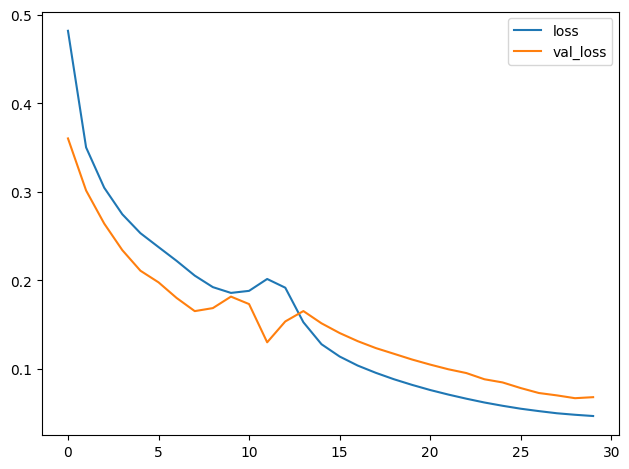

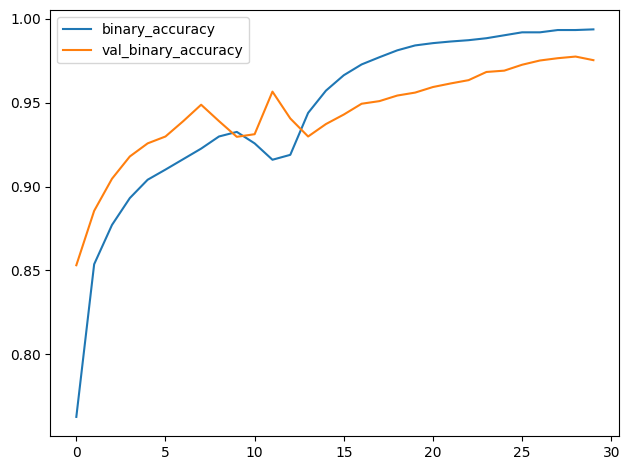

In [13]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [14]:
history_frame

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.481588,0.762556,0.360080,0.853039
1,0.349947,0.853625,0.301327,0.885480
2,0.304476,0.877076,0.263988,0.904632
3,0.274465,0.893101,0.233973,0.917921
4,0.253127,0.904045,0.210741,0.925738
5,0.237429,0.910104,0.197617,0.929842
6,0.221841,0.916357,0.179956,0.939027
7,0.205210,0.922611,0.165117,0.948798
8,0.192211,0.929842,0.168521,0.939027
9,0.185677,0.932578,0.181498,0.929646


In [15]:
from datetime import datetime
# Save the trained model to an HDF5 file
model.save(f"history_{str(datetime.now().date())}.h5")

from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("history_2023-08-22")

# Testing

In [15]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 6)                 49158     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 14763853 (56.32 MB)
Trainable params: 49165 (192.05 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [1]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

2023-08-23 14:01:47.725281: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 14:01:48.356767: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
# Load the trained model
model = load_model('history_2023-08-23.h5')

In [26]:
# Load and preprocess the test image
img_path = './test/truck.jpeg'
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

In [27]:
# Make predictions
predictions = model.predict(img_array)

1/1 [==============================] - 0s 27ms/step


In [28]:
# Interpret predictions for binary classification
predicted_class = "Positive" if predictions[0][0] > 0.5 else "Negative"
confidence = predictions[0][0]

In [29]:
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

Predicted class: Positive
Confidence: 1.00


In [128]:
def classify_by_folder(folder_path: str, entity: str):
    folder_path = f"{folder_path}{entity}/"
    # List all image files in the folder
    image_files = [
        f for f in os.listdir(folder_path) if f.endswith((".jpg", ".png", ".jpeg"))
    ]

    # Initialize lists to store results
    file_names = []
    predicted_classes = []
    confidences = []

    # Loop through each image and make predictions
    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        predictions = model.predict(img_array)
        predicted_class = "Positive/Car" if predictions[0][0] > 0.5 else "Negative"
        confidence = predictions[0][0]

        file_names.append(img_file)
        predicted_classes.append(predicted_class)
        confidences.append(confidence)
    # Create a DataFrame
    results_df = pd.DataFrame(
        {
            "File Name": file_names,
            "Predicted Class": predicted_classes,
            "Confidence": confidences,
        }
    )
    return results_df

In [160]:
results = []
entities = [
    "Airplanes",
    "Bikes",
    "Buses",
    "Cars",
    "Helicopters",
    "Ships",
    "Trains",
    "Trucks",
]

for entity in entities:
    result_df = classify_by_folder(
        folder_path="./data/car-or-truck/test/", entity=entity
    )
    results_grouped = result_df.groupby("Predicted Class").agg({"File Name": ["count"]})
    positives = results_grouped.loc["Positive/Car"][0]
    negatives = results_grouped.loc["Negative"][0]
    if entity == "Cars":
        accuracy = positives / (positives + negatives)
    else:
        accuracy = negatives / (positives + negatives)
    results.append(
        pd.DataFrame(
            {
                "transportation": [entity],
                "accuracy": [round(accuracy, 2)],
                "positives": [round(positives, 2)],
                "negatives": [round(negatives, 2)],
            }
        ).set_index("transportation")
    )

1/1 [==============================] - 0s 23ms/step


In [164]:
pd.concat(results).sort_values("accuracy")
# It seems like the model is still very simplistic; while it can differentiate transportations that are very different than a car, it struggles to differentiate the classes between the four-wheeled automobile category

,accuracy,positives,negatives
transportation,,,
Buses,0.40,314,208
Trucks,0.40,350,230
Cars,0.44,261,336
Trains,0.51,288,303
Bikes,0.86,84,515
Ships,0.86,81,518
Airplanes,0.90,61,538
Helicopters,0.93,40,524
